In [2]:
import json
import torch
import torch.nn as nn
import matplotlib.pyplot as plt
from typing import Type

In [755]:
with open("data/trump_data.json", "r") as file:
    trump_data = json.load(file)

with open("data/pepe_data.json", "r") as file:
    pepe_data = json.load(file)

with open("data/spx_data.json", "r") as file:
    spx_data = json.load(file)

with open("data/mstr_data.json", "r") as file:
    mstr_data = json.load(file)

with open("data/MARS_data.json", "r") as file:
    mars_data = json.load(file)

with open("data/NEIRO_data.json", "r") as file:
    neiro_data = json.load(file)

with open("data/HANA_data.json", "r") as file:
    hana_data = json.load(file)

with open("data/DOGGO_data.json", "r") as file:
    doggo_data = json.load(file)

with open("data/JOE_data.json", "r") as file:
    joe_data = json.load(file)

with open("data/FEFE_data.json", "r") as file:
    fefe_data = json.load(file)

with open("data/WOJAK_data.json", "r") as file:
    wojak_data = json.load(file)

In [724]:
"""# [present -> past] | [max_step -> min_step]
data = torch.tensor(spx_data['data']['attributes']['ohlcv_list'], dtype=torch.float32)  # AFTER_DEBUG: there's holes in data and intervals between points aren't the same!
# [past -> present] | [min_step -> max_step]
data = torch.flip(data, dims=[0])

X = data[:, 0]  # timestamps as inputs
Y = data[:, 4]  # close values as targets

# min-max X normalization
min_step, max_step = X[0].item(), X[-1].item()  # AFTER_DEBUG: perhaps trying Z-Score
Xn = (X - min_step) / (max_step - min_step)

# min-max Y normalization  
min_tgt, max_tgt = Y.min(), Y.max()
Yn = (Y - min_tgt) / (max_tgt - min_tgt)  # AFTER_DEBUG: after subtracting min value from each element, actual onae becomes zero, and it can lead to infinities when calculating fall ratios!"""

"# [present -> past] | [max_step -> min_step]\ndata = torch.tensor(spx_data['data']['attributes']['ohlcv_list'], dtype=torch.float32)  # AFTER_DEBUG: there's holes in data and intervals between points aren't the same!\n# [past -> present] | [min_step -> max_step]\ndata = torch.flip(data, dims=[0])\n\nX = data[:, 0]  # timestamps as inputs\nY = data[:, 4]  # close values as targets\n\n# min-max X normalization\nmin_step, max_step = X[0].item(), X[-1].item()  # AFTER_DEBUG: perhaps trying Z-Score\nXn = (X - min_step) / (max_step - min_step)\n\n# min-max Y normalization  \nmin_tgt, max_tgt = Y.min(), Y.max()\nYn = (Y - min_tgt) / (max_tgt - min_tgt)  # AFTER_DEBUG: after subtracting min value from each element, actual onae becomes zero, and it can lead to infinities when calculating fall ratios!"

In [827]:
def preprocess_data(raw_ohlcv: dict, features: str = "timestamp", targets: str = "close", epsilon: float = 1e-8) -> list[torch.tensor]:
    """
    This function transforms raw OHLCV data into a format that can be fed into a model. 

    Returns:
    1. The raw feature (X) and target (Y) tensors.
    2. The normalized feature (Xn) and target (Yn) tensors, scaled using min-max normalization with optional epsilon adjustment for zero values.
    """
    stoi = {"timestamp": 0,  # string to index mappings
            "open": 1,
            "high": 2,
            "low": 3,
            "close": 4,
            "volume": 5}
    
    data = torch.tensor(raw_ohlcv['data']['attributes']['ohlcv_list'], dtype=torch.float32)  # list -> torch.tensor
    data = torch.flip(data, dims=[0])  # [present -> past] -> [past -> present]

    out = [data[:, stoi[features]], data[:, stoi[targets]]]  # X, Y

    for set in out[:2]:
        setn = (set - set.min()) / (set.max() - set.min())  # Xn, Yn
        setn = setn + (setn == 0).float() * epsilon  # epsilon adjustment
        out.append(setn) 
    
    return [row.view(-1, 1) for row in out]  # [X, Y, Xn, Yn] as (-1, 1) column tensors


def polynomial_features(x: torch.tensor, max_pow: int) -> torch.tensor:
    """
    This function takes a tensor of shape (-1, 1) and returns a new tensor 
    where each column corresponds to the input features raised to the 
    powers from 1 to 'max_pow'.
    """
    assert x.dim() == 2 and x.shape[-1] == 1, f"Input tensor must be of shape (-1, 1). Got {tuple(x.shape)} instead."
    powers = torch.arange(1, max_pow + 1)
    return torch.pow(x, powers)


class MLP(nn.Module):

    def __init__(self, ipt_size: int, hidden_ns: list, act_layer: Type[nn.Module] = nn.ELU) -> None:
        super().__init__()
        self.ipt_size = ipt_size

        layers = [nn.Linear(self.ipt_size, hidden_ns[0]), act_layer()]  # input layer + relu
        for n0, n1 in zip(hidden_ns[:-1], hidden_ns[1:]):  # hidden layers + relus
            layers.extend([nn.Linear(n0, n1), act_layer()])
        layers.append(nn.Linear(hidden_ns[-1], 1))  # output layer

        self.layers = nn.Sequential(*layers)  # stack layers
    
    def forward(self, x_polynomial: torch.tensor) -> torch.tensor:
        return self.layers(x_polynomial)
    
    def get_original_feature_gradients(self, orig_features: torch.tensor) -> torch.tensor:
        self.set_gradients_to_none()  # clean gradients
        orig_features.requires_grad_(True) # include in computation

        Xpol = polynomial_features(orig_features, self.ipt_size)
        approximations = self(Xpol)
        approximations_sum = approximations.sum()  # single value to backward from

        approximations_sum.backward()
        grads_wrt_orig_features = orig_features.grad

        orig_features.grad = None  # clean gradient
        orig_features.requires_grad_(False)  # exclude from computation
        self.set_gradients_to_none()  # clean gradients

        return grads_wrt_orig_features
    
    def set_gradients_to_none(self) -> None:
        for param in self.parameters():
            param.grad = None


def train_mlp(model: MLP, Xtr: torch.tensor, Ytr: torch.tensor, verbosity: bool = False) -> None:
    """
    Trains the provided model using the given training datasets until 
    either a target performance metric is achieved 
    or a specified number of optimization steps are completed.
    """
    mse_loss = nn.MSELoss(reduction="mean")
    optimizer = torch.optim.AdamW(model.parameters(), lr=1e-3)
    
    loss, target_loss = torch.tensor(float("inf")), 0.005
    iter, max_iters = 0, 10000
    
    while loss.item() > target_loss and iter < max_iters:
        optimizer.zero_grad(set_to_none=True)
        preds = model(Xtr)
        loss = mse_loss(preds, Ytr)
        loss.backward()
        optimizer.step()
        iter += 1
    if verbosity is True:
        print(f"{iter} iterations, {loss} loss")

In [828]:
X, Y, Xn, Yn = preprocess_data(wojak_data, epsilon=0.0)

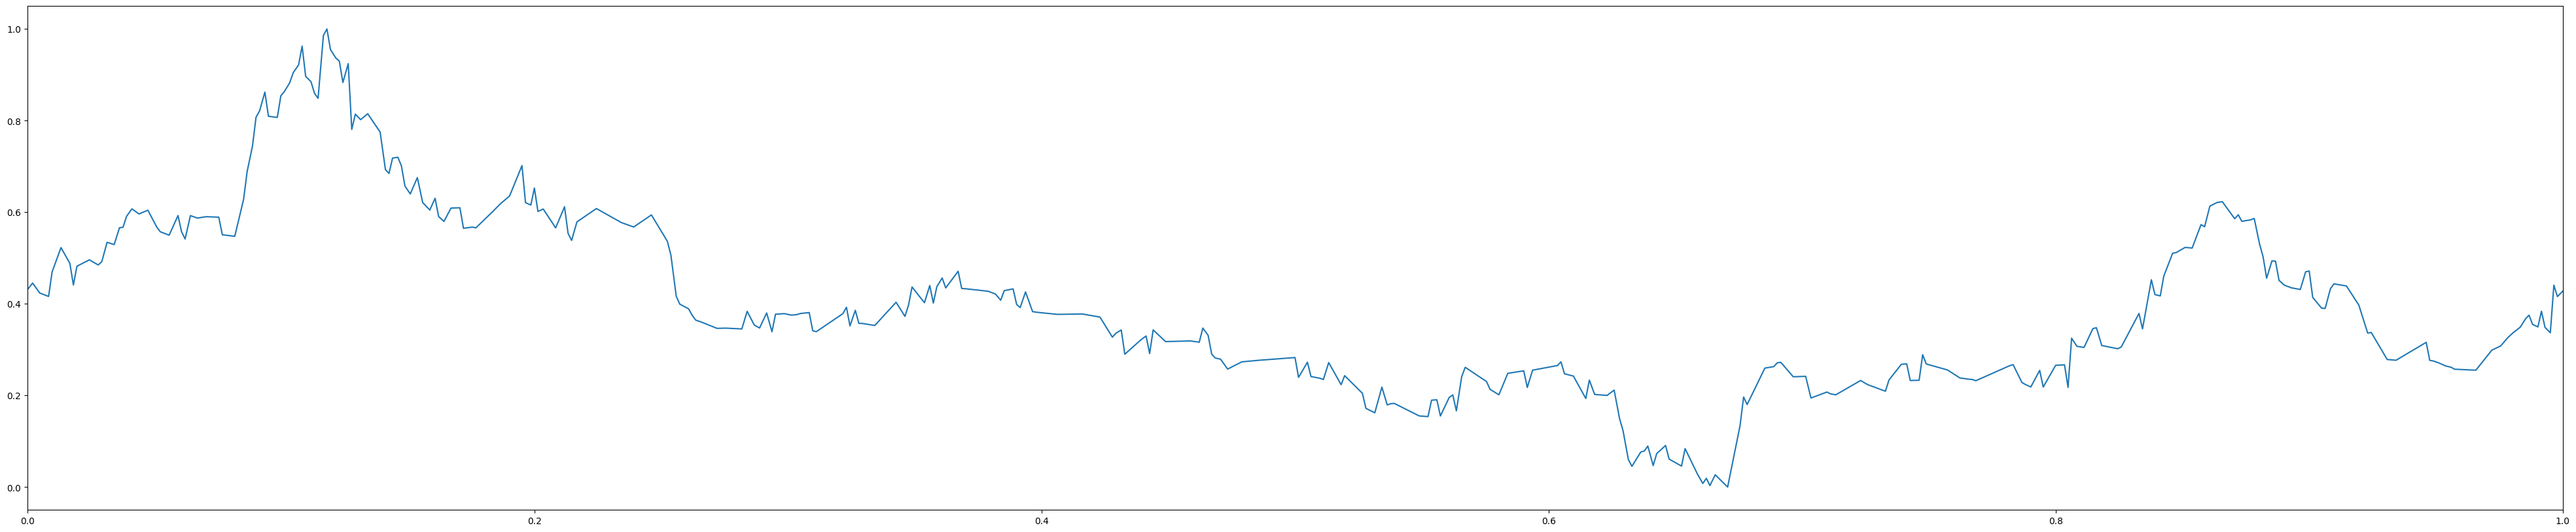

In [816]:
# Approximated function
plt.figure(figsize=(50, 10))
plt.plot(Xn, Yn)
plt.margins(x=0);

In [829]:
input_size = 2
hidden_neurons = [8, 16, 16, 16, 8]

model = MLP(input_size, hidden_neurons, nn.LeakyReLU)
Xp = polynomial_features(Xn, input_size)

train_mlp(model, Xp, Yn, verbosity=True)
preds = model(Xp)

594 iterations, 0.004983500111848116 loss


In [763]:
"""input_size = 2
hidden_neurons = [8, 16, 16, 16, 8]  # [4, 8, 4]  # [100, 200, 100]

model = MLP(input_size, hidden_neurons, nn.LeakyReLU)
Xp = polynomial_features(Xn, input_size)

mse_loss = nn.MSELoss(reduction="mean")
optimizer = torch.optim.AdamW(model.parameters(), lr=1e-3)"""

In [771]:
"""num_iters = 1000
for i in range(num_iters):
    optimizer.zero_grad(set_to_none=True)
    preds = model(Xp)
    loss = mse_loss(preds, Yn)
    print(loss)
    loss.backward()
    optimizer.step()"""

tensor(0.0058, grad_fn=<MseLossBackward0>)
tensor(0.0057, grad_fn=<MseLossBackward0>)
tensor(0.0057, grad_fn=<MseLossBackward0>)
tensor(0.0056, grad_fn=<MseLossBackward0>)
tensor(0.0056, grad_fn=<MseLossBackward0>)
tensor(0.0055, grad_fn=<MseLossBackward0>)
tensor(0.0054, grad_fn=<MseLossBackward0>)
tensor(0.0054, grad_fn=<MseLossBackward0>)
tensor(0.0053, grad_fn=<MseLossBackward0>)
tensor(0.0052, grad_fn=<MseLossBackward0>)
tensor(0.0052, grad_fn=<MseLossBackward0>)
tensor(0.0051, grad_fn=<MseLossBackward0>)
tensor(0.0051, grad_fn=<MseLossBackward0>)
tensor(0.0050, grad_fn=<MseLossBackward0>)
tensor(0.0050, grad_fn=<MseLossBackward0>)
tensor(0.0049, grad_fn=<MseLossBackward0>)
tensor(0.0049, grad_fn=<MseLossBackward0>)
tensor(0.0049, grad_fn=<MseLossBackward0>)
tensor(0.0048, grad_fn=<MseLossBackward0>)
tensor(0.0048, grad_fn=<MseLossBackward0>)
tensor(0.0047, grad_fn=<MseLossBackward0>)
tensor(0.0047, grad_fn=<MseLossBackward0>)
tensor(0.0046, grad_fn=<MseLossBackward0>)
tensor(0.00

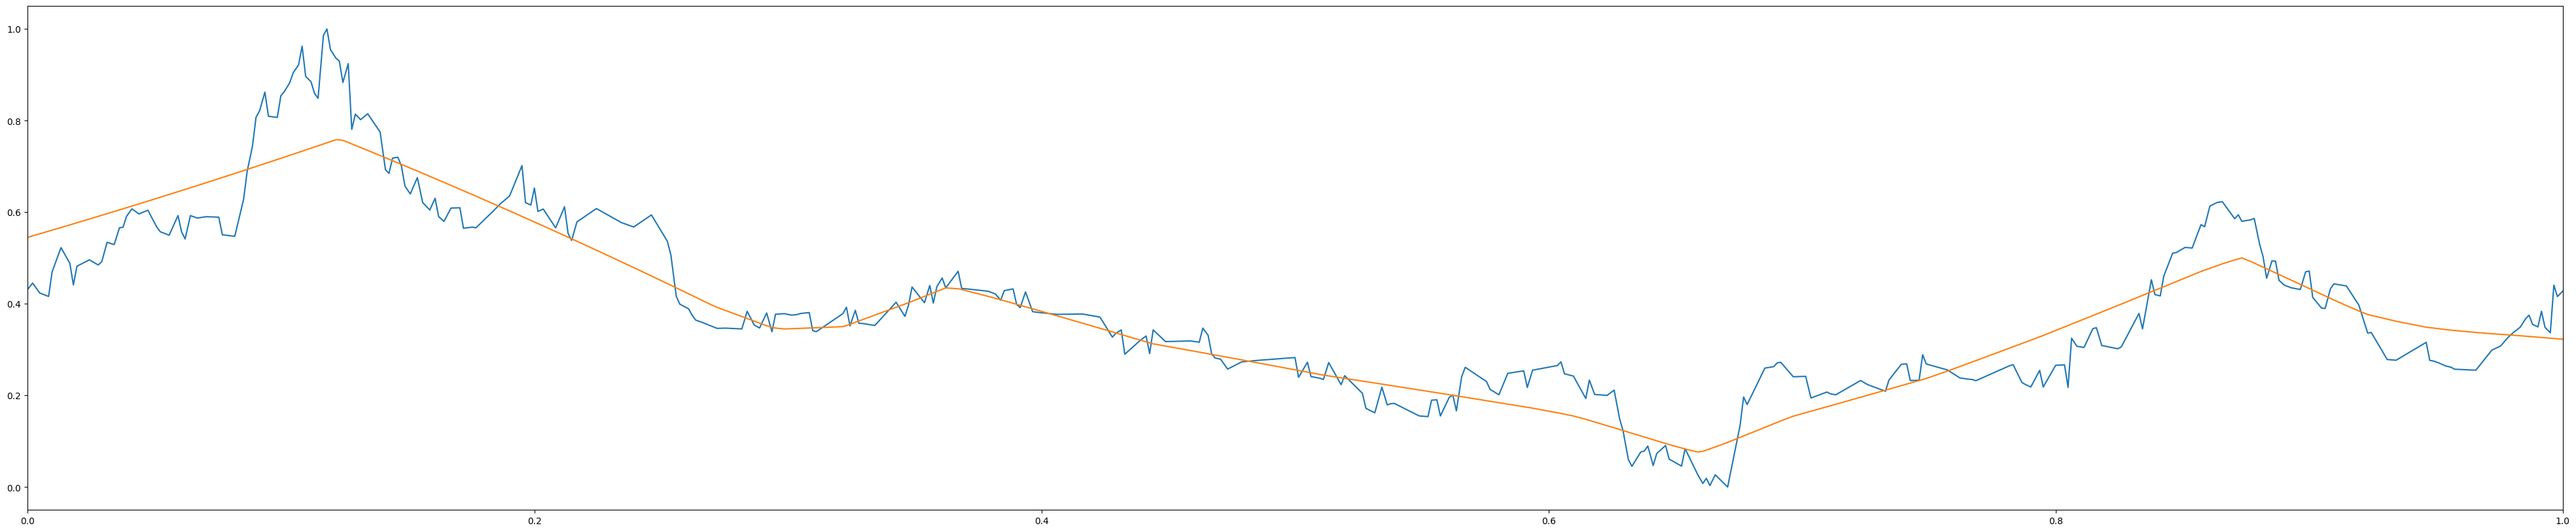

In [818]:
# Approximated function
plt.figure(figsize=(50, 10))
plt.plot(Xn, Yn)
# Approximation
plt.plot(Xn, preds.detach())
plt.margins(x=0);

In [749]:
"""# Turn on tracking
Xn.requires_grad_(True)

Xtr1 = polynomial_features(Xn, input_size)
out = model(Xtr1)
sumout = out.sum()
sumout.backward()
# Gradients with respect to Xn
grads = Xn.grad

# Clear gradients, turn off tracking
Xn.grad = None
Xn.requires_grad_(False);"""

'# Turn on tracking\nXn.requires_grad_(True)\n\nXtr1 = polynomial_features(Xn, input_size)\nout = model(Xtr1)\nsumout = out.sum()\nsumout.backward()\n# Gradients with respect to Xn\ngrads = Xn.grad\n\n# Clear gradients, turn off tracking\nXn.grad = None\nXn.requires_grad_(False);'

In [923]:
grads = model.get_original_feature_gradients(Xn)

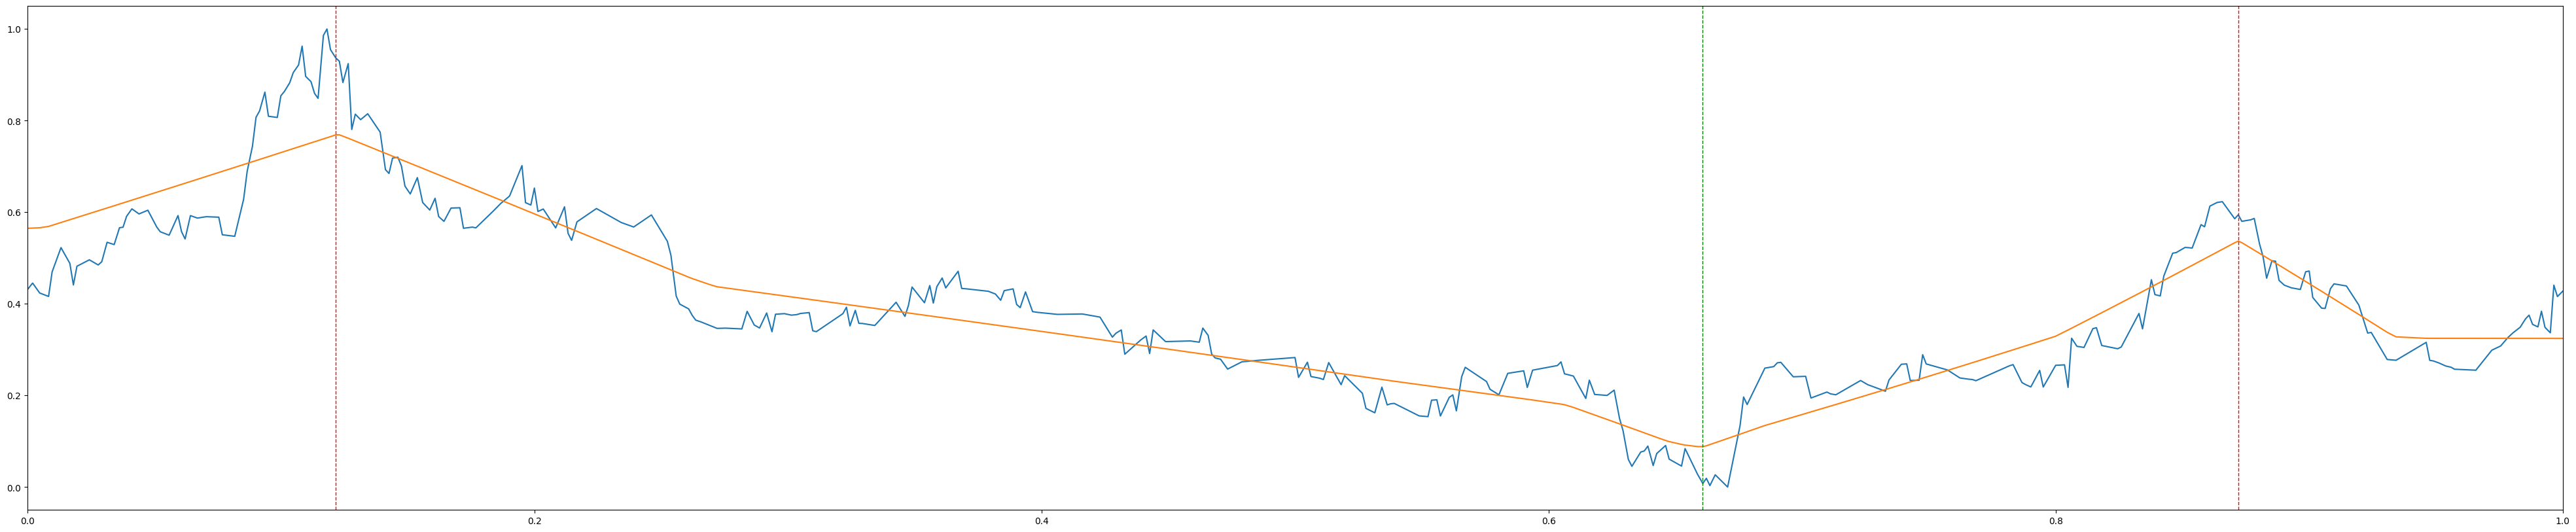

In [974]:
fig, ax = plt.subplots(figsize=(50, 10))

ax.plot(Xn, Yn)
ax.plot(Xn, preds.detach())

extremums = [0]
for i, (prev, next) in enumerate(zip(grads, grads[1:])):
    if prev <= 0 and next > 0:
        ax.axvline(x=Xn[i], color='green', linestyle='--', linewidth=1)
        extremums.append(i)
    elif prev > 0 and next <= 0:
        ax.axvline(x=Xn[i], color='red', linestyle='--', linewidth=1)
        extremums.append(i)
extremums.append(349)

ax.margins(x=0);

In [975]:
extremums

[0, 54, 232, 300, 349]

In [976]:
for i, (prev, next) in enumerate(zip(extremums, extremums[1:])):
    print(f"{i}: {(Y[next] / Y[prev] - 1).item():+.17f} %")  # AFTER_DEBUG: devision by zero can occur here! 

0: +0.07995009422302246 %
1: -0.13589370250701904 %
2: +0.09930300712585449 %
3: -0.02570664882659912 %


In [982]:
max_idx = grads.shape[0] - 1  # max index in gradients array

sign_changes = torch.where(grads[:-1] * grads[1:] <= 0)[0]  # after these indexes sign changes in gradients tensor
extremums = torch.cat([torch.tensor([0]), sign_changes, torch.tensor([max_idx])])  # and graph boundaries

ratios = Y[extremums[1:]] / Y[extremums[:-1]] - 1  # get fall ratios on each interval
max_fall_idx = ratios.argmin()  # get the steepest fall index
s, e = extremums[max_fall_idx], extremums[max_fall_idx + 1]  # restore interval edges

buff_size = 10
s = torch.clamp(s - buff_size, min=0)
e = torch.clamp(e + buff_size, max=max_idx + 1)

min_val, max_val = torch.aminmax(Y[s:e])
res = min_val / max_val - 1.0
print(res)

tensor(-0.1450)
